# **Basics of Mobile robotics**
### **Project**

**Paul Huot-Marchand** 
**Luca**
**Manuela** 
 

**Date:** *2025*

# **INTRODUCTION**
Our project take place on a rectangular white environment with black obstacles of any shapes a black circle as goal and a  black isocele triangle on the robot. The goal was to implement global navigation using the camera provided creating a global occupancy map, then applying an A* algorithm to find an optimized path. A filter was implemented to track position of the robot. Local avoidance was implemented to avoid la minuit added obstacles using thymio infrared sensors.

## **I Computer Vision**
The steps of our computer vision part is as follow : 
- Detect the environment,
- Correct percpective,
- detect obstacles and goal to fill occupancy map
- detect the robot

To do so a general filtering framework was adopted. First convert to gray scale, apply bilateral filter to enhance edge and remove noise, apply canny filter to detect edges, apply morphological filter to close as much as possib

In [1]:
!pip install tdmclient numpy scipy opencv-python tqdm


In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import cv2
import tqdm
from Computer_vision import cv as com
#import Filtering as flt 
from Global_Nav import global_nav as gb
import matplotlib.pyplot as plt

import math as m
import numpy as np
from collections import deque
from matplotlib.animation import FuncAnimation

from Filtering import Control_fromEKF as control
from Filtering import Filtering as filt
from Local_Nav import local_nav as ln



In [7]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()

node = await client.wait_for_node()
await node.lock() 

Node 7e5a04de-7cbe-4397-8545-f33016b69c2f

In [2]:
def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale
    
#================HYPERPARAMETESRS======================

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 10
B2_O = 80
B3_O = 80
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 5
B2_C = 8
B3_C = 8
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 10
B3_T = 10
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
Min_area_env = 1920*1080*0.4   #Min area in pixel of the env
Env_approx = 0.01

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.8   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.2
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = False

# IR SENSORS CALIBRATION
#========================================================

In [3]:
if DEBUG : 
    import matplotlib.pyplot as plt
    %matplotlib inline
#GLOBAL FRAMEWORK TO USE VISION
#EXECUTE CELL ABOVE WITH DEBUG = TRUE FOR TUNING UNTIL EVERYTHING IS CORRECTLY FILTERED AND FOUND
cap = cv2.VideoCapture(1)
    
if not cap.isOpened():
    print("Could not access webcam")






ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND


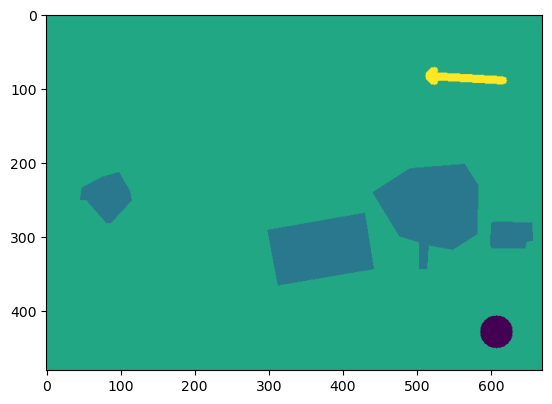

In [22]:
#INITIALIZATION
#GET A FRAME
img = com.get_picture_optimized(cap)
#img = cv2.imread("02.png")
#COMPUTE TRANSFORMATION MATRIX
matrix = com.matrix_perspective(img)
#CORRECT IMAGE
transformed_image = com.convert_perspective(img,matrix)

#PLOTTING
if DEBUG: 
    plt.figure()
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Corrected Image")
    plt.axis('off')
    plt.show()


#GET GLOBAL MAP
global_map = com.get_map(transformed_image)

#GET ROBOT POSITION AND ORIENTATION
robot = com.get_robot(transformed_image)


length = 100
end_x = int(robot[0][0] + length * np.cos(robot[1]))
end_y = int(robot[0][1] + length * np.sin(robot[1]))
end_point = (end_x, end_y)
global_map4plot = global_map.copy()
cv2.arrowedLine(global_map4plot, [int(robot[0][0]), int(robot[0][1])], end_point, color=(2, 2, 2), thickness=10)
plt.imshow(global_map4plot)
plt.show()
if DEBUG : 
    global_map4plot = global_map.copy()
    cv2.arrowedLine(global_map4plot, robot[0], end_point, color=(2, 2, 2), thickness=10)
    plt.imshow(global_map4plot)
    plt.axis('off')
    plt.show()


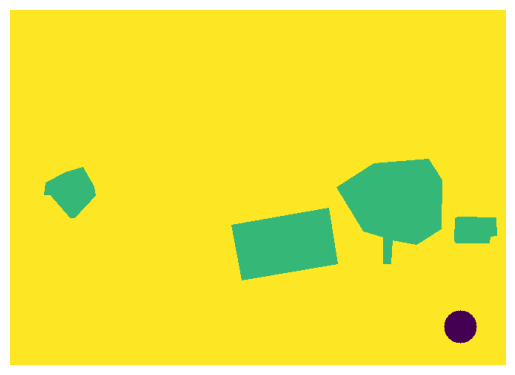

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[-3 -1  0]


In [24]:
global_map = global_map.astype(int)
solved = global_map[:]
path = path = gb.a_star(global_map, robot[1], 0.25, 
                 (int(round(robot[0][1])), int(round(robot[0][0]))))


480
670
89
618
253730


In [ ]:
from Computer_vision import cv as com
import cv2
import time
import numpy as np
from Global_Nav import global_nav as gb

async def main():
    #---- VIZUALIZATION PARAMETERS ----
    # Set camera resolution
    w = 1920
    h = 1080
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, w)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h)
    cap.set(cv2.CAP_PROP_EXPOSURE, -7)
    time.sleep(0.1)  # let the camera apply settings
    
    # Desired display size
    display_width = 960
    display_height = 540
    
    
    #---- INITIALIZATION ---
    ret, frame = cap.read()
    matrix = com.matrix_perspective(frame)
    transformed_frame = com.convert_perspective(frame, matrix)
    
    
    global_map = com.get_map(transformed_frame)
    robot = com.get_robot(transformed_frame)
    solved = global_map[:]
    #FIND PATH
    path = path = gb.a_star(global_map, robot[1], 0.5, 
                     (int(round(robot[0][1])), int(round(robot[0][0]))))
    
    
    #--- NAVIGATION PARAMETERS ---
    
    # params ekf
    Ts = 0.1  # time step in seconds
    L = 95  # distance between wheels in mm
    speed_to_mms = 0.3375  # conversion factor from thymio speed units to mm/s from solution ex.8 (in our measurement it was 0.43478260869565216)
    
    # Process noise for EKF (tune) (from model-mismatch/random-walk/control execution)
    q_proc = (
        1e-10, 1e-10, 1e-3,   # q_x, q_y, q_theta (model mismatch)
        75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
        1e-2, 1e-5          # q_v_bias, q_omega_bias (random walk on v, omega)
    )
    # Camera measurement noise (tune)
    r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
    r_mot = (75.72, 0.002692)    # motor noise on v, omega
    
    def pixel_to_world_mm(pos):
        px, py = pos
        x = 10 * px * (L / SIZE[1])
        y = 10 * py * (W / SIZE[0])
        return x, y
    
    conv_x = 10 * (L / SIZE[1])
    conv_y = 10 * (W / SIZE[0])
    # 1) buffers
    traj = deque(maxlen=2000)   # (x,y)
    # convert path!
    waypoints = control.remove_collinear(control.grid_to_mm(path, cell_size_mm_x=conv_x, cell_size_mm_y=conv_y))
    plot_wps = waypoints
    way_mm = control.grid_to_mm(path, cell_size_mm_x=conv_x, cell_size_mm_y=conv_y)
    
    
    
    # --- INIT EKF----
    
    #image = transformed_frame
    pos, angle, __ = com.get_robot(transformed_frame)
    pos = pixel_to_world_mm(pos)
    x = pos[0]
    y = pos[1]
    x0=[x, y, angle,0,0]
    ekf = filt.EKFState(x0, P0=1000*np.eye(5))
    #print(ekf)
    
    # --- PLOTTING ---
    ekf_traj = [] # for plot
    # memory for plots
    def ekf_get_state():
        s = ekf.get_state()  # (x,y,theta)
        ekf_traj.append((s[0], s[1], s[2]))  # log x,y each time it's called
        return s
    image = []  # ?????
    
    
    
    #---VISU---
    for i in path : 
        global_map[i[0]][i[1]] = -4 # marker for path in my debug functions
    
    drawing_robot_real = []
    drawing_robot_esti = []
    
    #--- CONNECT TO THYMIO ---
    try:
        aw(node.lock()) # lock the node for R/W
    except Exception:
        pass # ignore it it wasn't locked
    
    aw(node.stop())
    print("Connected:", node)
    motors = aw(node.wait_for_variables({"motor.left.speed","motor.right.speed"}))
    
    
    #--- HELPER FUNCTIONS FOR EKF --- 
    def get_motor_meas(): 
        # raw speeds in Thymio units (instantaneous)
        vl = int(node.v.motor.left.speed)
        vr = int(node.v.motor.right.speed)
        print("get_motor_meas", vl, vr)
        # convert to v [mm/s], omega [rad/s] 
        v, w = filt.motors_to_vw(vl, vr, speed_to_mms, L) 
        return np.array([v, w], dtype=float)
    
    def get_cam_meas(image=None):
        # get position from camera
        if image is not None:
            pos, angle, Rob = com.get_robot(image)
            #x = SIZE[1] - pos[0] 
            if Rob ==  False:
                return None
            pos = pixel_to_world_mm(pos)
            x = pos[0]
            y = pos[1]
            print("Camera Robot Position", x, y, angle)
            return np.array([x, y, angle], dtype=float)
        return None
    
    
    
    obstacle_not_passed = False
    
    while True:
        await asyncio.sleep(0)
        
        #--- GET IMAGE ---
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break
    
        # Apply perspective transform
        transformed_frame = com.convert_perspective(frame, matrix)
        transformed_frame_visu = transformed_frame.copy() 
        # transformed_frame = current image we can work with
    
    
        #--- VISU ---
        # Draw obstacles in RED
        for i in range(len(global_map)):
            for j in range(len(global_map[0])):
                if global_map[i][j] == -1:        # obstacle
                    cv2.circle(transformed_frame_visu, (j, i), 2, (0,0,255), -1)
                if global_map[i][j] == -3:        # obstacle
                    cv2.circle(transformed_frame_visu, (j, i), 2, (255,0,0), -1)
    
        # Draw path in green
        for i, j in path:
            cv2.circle(transformed_frame_visu, (j, i), 2, (0,255,0), -1)
            
        if obstacle_not_passed : 
            cv2.putText(transformed_frame_visu, "Local obstacle detected", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
        # Draw Robot position
        robot, angle, found = com.get_robot(transformed_frame)
        
        if found : 
            length = 20
            end_x = int(robot[0] + length * np.cos(angle))
            end_y = int(robot[1] + length * np.sin(angle))
            end_point = (end_x, end_y)
            
            robot1 = [int(robot[0]),int(robot[1])]
            
            drawing_robot_real.append([robot1, end_point])
            for i in range(len(drawing_robot_real)):
                robot1 = drawing_robot_real[i][0]
                end_point = drawing_robot_real[i][1]
                cv2.arrowedLine(transformed_frame_visu, robot1, end_point, color=(2, 2, 2), thickness=2)
            found = False
    
    
        #--- Camera Window ---
        # Show the transformed frame live
        small_transformed = cv2.resize(transformed_frame_visu, (display_width, display_height))
        cv2.imshow("Transformed Camera Feed", small_transformed)
    
        # Resize for display only
        small_frame = cv2.resize(frame, (display_width, display_height))
    
        # Show the live frame
        cv2.imshow("Live Camera Feed", small_frame)
    
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
        
        #--- GlOBAL NAVIGATION ---
        if waypoints :
            # get motion params
            vl_cmd, vr_cmd = control.get_cmd()
            z_mot= get_motor_meas()
            z_cam = get_cam_meas(transformed_frame)
            
            # EKF STEP
            ekf.step(vl_cmd, vr_cmd, z_cam, r_cam=r_cam, z_mot=z_mot, r_mot=r_mot, Ts=Ts, q_proc=q_proc)
            #print("ekf results:", ekf.x, ekf.P)
            state = ekf_get_state()
            # motion control
            print("waypoints:", waypoints)
    
            #--- LOCAL AVOIDANCE --- 
            if not(ln.prox_less_threshold(list(node["prox.horizontal"][:5]), 1500)) or obstacle_not_passed :
                objectif = (waypoints[0][0]/10, waypoints[0][1]/10) 
                curr_dir = (100*m.cos(state[2]), 100*m.sin(state[2]))
                curr_pos = (state[0]/10, state[1]/10)
                obstacle_not_passed = True
                v = {}
                await node.wait_for_variables({"prox.horizontal"})
                prox_read = list(node["prox.horizontal"])
    
                #--- TEST IF OBSTACLED IS PASSED ---
                if (ln.prox_less_threshold(prox_read, 1000)) and obstacle_not_passed:
                    print("PASSED")
                    v["motor.left.target"] = [100]
                    v["motor.right.target"] = [100]
                    await node.set_variables(v)
                    await client.sleep(2)
                    obstacle_not_passed = False
                    continue
                
                vect = ln.vect_calculation(objectif, (curr_pos),curr_dir,  prox_read[:5], 100, debug=False)
                norm_vect = m.sqrt(vect[0]**2 + vect[1]**2)
                curr_dir_norm = m.sqrt(curr_dir[0]**2+curr_dir[1]**2)
                angle_command = m.atan2(vect[1], vect[0])
                delta_speed = np.sign(angle_command)*min(abs(angle_command/ln.WAIT_TIME*800/m.pi), 300)
                left_speed = int(100+(delta_speed/2))
                right_speed = int(100-(delta_speed/2))
                v["motor.left.target"] = [left_speed]
                v["motor.right.target"] = [right_speed]
                await node.set_variables(v)
                #print(f"{second_counter} : curr_pos = ({curr_pos[0]:.2f}, {curr_pos[1]:.2f}), vect = {angle_command:.2f} and delta_speed = {delta_speed:.2f}, curr_dir = ({curr_dir[0]:.2f}, {curr_dir[1]:.2f})")
                await client.sleep(ln.WAIT_TIME)
                continue
                #print(curr_dir, delta_speed*WAIT_TIME*m.pi/100, m.cos(delta_speed*WAIT_TIME*m.pi/100)
    
            #--- FOLLOW THE GLOBAL PATH ---
            obstacle_not_passed = False
            waypoints = aw(control.follow_path(node, state, waypoints, v_cmd=180, kp_heading=50.0,
                          pos_tol=12.0))
        else : 
            aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
            aw(node.unlock())
            
    
        # quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        """
        esti = True
        if esti : 
            estimated = [0,0]
            drawing_robot_esti.append(estimated)
            for i in range(len(drawing_robot_esti)):
                loc = drawing_robot_esti[i]
                cv2.circle(transformed_frame, loc, 2, (0,0,255), -1)
            esti = False
        
        
    
        if local_obstacle : 
            cv2.putText(
            transformed_frame,          # image
            "Local obstacle detected",  # text
            (100, 100),                   # position (x, y)
            cv2.FONT_HERSHEY_SIMPLEX,   # font
            1,                          # scale (size)
            (255, 0, 0),            # color (B, G, R)
            2,                          # thickness
            cv2.LINE_AA                 # anti-aliasing
            )
        """

# run main
aw(main())

# Release resources
cap.release()
cv2.destroyAllWindows()
